##Mounts Google drive on Colab


In [1]:
#for setting up on colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Installing required libraries

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [3]:
!pip install progressbar
import progressbar
#matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
% matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import requests
from bs4 import BeautifulSoup
import string


In [5]:
file = open('/content/drive/My Drive/App/Test1.txt','w+')
uniqueWords = set()
for i in range(3, 40):
    resp = requests.get('https://jang.com.pk/roman/news/'+str(i))
    HTML = resp.text
    soup = BeautifulSoup(resp.text, 'html.parser')
    pTag = soup.find_all('p')
    pTag=pTag[1:len(pTag)-1] #removes empty p tags and copyright p tags
    #remove all sorts of tags
    i = 0
    para=''
    while i < len(pTag):
        soup=BeautifulSoup(str(pTag))
        para=soup.get_text()
        para = para[1:len(para)-3] #removes full stop, brackets and space
        i+=1
    #remove punctuations and special characters and digits
    removal=".,!?<>(){}[]<>\\;'+-=~:|/*&^%#$`"
    para=[x for x in para if x not in removal and not x.isdigit() and x!='\xa0']   
    para=''.join(para)
    
    #to remove white spaces created by removing numbers and urdu words
    para=para.split(' ')
    para=[x for x in para if x]
    para=[x for x in para if ord(x[0]) in range(0,128)]  #to remove urdu 
    for x in para:
      uniqueWords=uniqueWords.union({x})
    para=''.join(para[i]+' ' for i in range(0,len(para)))
    file.write(para)

print(len(uniqueWords))
file.close()  
uniqueWords
file = open('/content/drive/My Drive/App/Words.txt','w+')
for i in uniqueWords:
  file.write(i+'\n')
  
file.close()  
#uniqueWords

2412


In [0]:
CONTEXT_SIZE = 5
EMBEDDING_DIM = 100
EPOCHS = 5

## Reading a file

In [0]:

filename = "/content/drive/My Drive/App/Test1.txt"
with open(filename, "rb") as file:
        raw_text = file.read().decode("utf-8").strip()
#raw_text

function for reading a file and converting into list of tokens

In [0]:
def read_file(file_name):
    with open(filename, "rb") as file:
        processed_text = word_tokenize(file.read().decode("utf-8").strip())
    return processed_text
processed_text = read_file(filename)
#processed_text

## preprocessing

In [0]:
def mini_processing(processed_text):
    vocab = {}
    ix_to_word = {}
    word_to_ix = {}
    total = 0.0
    for word in processed_text:
        if word not in vocab:
            vocab[word] = 0
            ix_to_word[len(word_to_ix)] = word
            word_to_ix[word] = len(word_to_ix)
        vocab[word] += 1.0
        total += 1.0
    return vocab, ix_to_word, word_to_ix
vocab,ix_to_word,word_to_ix = mini_processing(processed_text)
#print("Vocaublary:", vocab)
#print("ix_to_word",ix_to_word)
#print("word_to_ix",word_to_ix)

## generating training data

In [10]:
vocab

{'Karachi': 16.0,
 'se': 194.0,
 'Gwadar': 2.0,
 'Iran': 3.0,
 'aur': 154.0,
 'dubai': 1.0,
 'tak': 1.0,
 'fairy': 6.0,
 'service': 7.0,
 'chalanay': 4.0,
 'ke': 533.0,
 'mansoobay': 10.0,
 'mein': 293.0,
 'sarmaya': 3.0,
 'kaari': 3.0,
 'liye': 55.0,
 'sirf': 11.0,
 'aikcompany': 1.0,
 'samnay': 10.0,
 'aa': 5.0,
 'saki': 1.0,
 'woh': 26.0,
 'bhi': 44.0,
 'sarkari': 3.0,
 'hai': 213.0,
 'is': 60.0,
 'kisi': 10.0,
 'niji': 1.0,
 'company': 7.0,
 'ny': 39.0,
 'dilchaspi': 3.0,
 'ka': 133.0,
 'izhaar': 5.0,
 'nahi': 48.0,
 'kyajs': 1.0,
 'ki': 309.0,
 'wajah': 15.0,
 'nakami': 1.0,
 'khadsha': 2.0,
 'haisecretary': 1.0,
 'ports': 4.0,
 'and': 8.0,
 'shipping': 4.0,
 'Khalid': 2.0,
 'Parvez': 4.0,
 'mutabiq': 26.0,
 'ko': 132.0,
 'kamyaab': 4.0,
 'bananay': 4.0,
 'mukhtalif': 11.0,
 'operations': 2.0,
 'per': 7.0,
 'ghour': 2.0,
 'hain': 97.0,
 'wazeh': 9.0,
 'rahay': 19.0,
 'elaan': 4.0,
 'october': 1.0,
 'kiya': 8.0,
 'gaya': 50.0,
 'tha': 21.0,
 'taakay': 4.0,
 'Pakistan': 33.0,
 'o': 

In [0]:

def gather_training_data(processed_text, word_to_ix, context_size):
    training_data = []
    for i, word in enumerate(processed_text):
        back_i = i - 1
        back_c = 0
        forw_i = i + 1
        forw_c = 0
        while (back_i >= 0 and back_c < context_size):
            training_data.append(([word_to_ix[word]], word_to_ix[processed_text[back_i]]))
            back_i -= 1
            back_c += 1
        while (forw_i < len(processed_text) and forw_c < context_size):
            training_data.append(([word_to_ix[word]], word_to_ix[processed_text[forw_i]]))
            forw_i += 1
            forw_c += 1
    return training_data
training_data = gather_training_data(processed_text, word_to_ix, CONTEXT_SIZE)
#training_data

## Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.linear(embeds)
        log_probs = F.log_softmax(out)
        return log_probs

In [0]:
model = SkipGram(len(vocab),EMBEDDING_DIM)


## Loss and optimization


In [14]:
model

SkipGram(
  (embeddings): Embedding(2412, 100)
  (linear): Linear(in_features=100, out_features=2412)
)

In [0]:
class NEGLoss(nn.Module):
    def __init__(self, ix_to_word, word_freqs, num_negative_samples=5,):
        super(NEGLoss, self).__init__()
        self.num_negative_samples = num_negative_samples
        self.num_words = len(ix_to_word)
        self.distr = F.normalize(torch.Tensor(
            [word_freqs[ix_to_word[i]] for i in range(len(word_freqs))]).pow(0.75), dim=0
        )

    def sample(self, num_samples, positives=[]):
        weights = torch.zeros((self.num_words, 1))
        for w in positives: weights[w] += 1.0
        for _ in range(num_samples):
            w = torch.multinomial(self.distr, 1)[0]
            while (w in positives):
                w = torch.multinomial(self.distr, 1)[0]
            weights[w] += 1.0
        return weights

    def forward(self, input, target):
        #print("target= ",target)
        #print("sample", self.sample(self.num_negative_samples, positives=target.data.numpy()))
        #print("input = ",input)
        #print("\n")
        return F.nll_loss(input, target,
            self.sample(self.num_negative_samples, positives=target.data.numpy()))

In [0]:
loss_function = NEGLoss(ix_to_word,vocab)
optimizer = optim.SGD(model.parameters(), lr=0.001)

## TRAINING 

In [17]:
losses=[]
for epoch in range(EPOCHS):
    total_loss = torch.Tensor([0])
    print("Beginning epoch %d" % epoch)
    progress_bar = progressbar.ProgressBar()
    for context, target in progress_bar(training_data):
        context_var = autograd.Variable(torch.LongTensor(context))
        model.zero_grad()
        log_probs = model(context_var)
        #print("target",target)
        #print("log_probs",log_probs)
        #print('\n')
        loss = loss_function(log_probs, autograd.Variable(
            torch.LongTensor([target])))
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    print("Epoch %d Loss: %.5f" % (epoch, total_loss[0]))
    losses.append(total_loss)

Beginning epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 0 Loss: 697841.25000
Beginning epoch 1


Epoch 1 Loss: 650774.25000
Beginning epoch 2


Epoch 2 Loss: 628822.93750
Beginning epoch 3


Epoch 3 Loss: 614920.25000
Beginning epoch 4


Epoch 4 Loss: 604675.87500


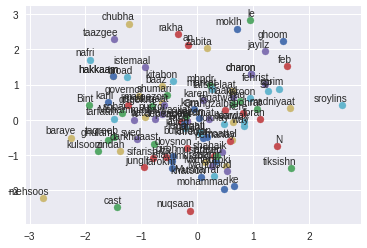

In [18]:
indices = np.random.choice(np.arange(len(vocab)), size=100, replace=True)
for ind in indices:
    word = list(vocab.keys())[ind]
    input = autograd.Variable(torch.LongTensor([word_to_ix[word]]))
    vec = model.embeddings(input).data[0]
    x, y = vec[0], vec[1]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
    plt.savefig("graph0.png")

## TSNE Visualization

In [0]:
lst=[]
for word in uniqueWords:
  inputs = autograd.Variable(torch.LongTensor([word_to_ix[word]]))
  vec = model.embeddings(inputs).data[0]
  vec = vec.numpy()
  lst.append(vec)
tsne_list = TSNE(n_components=2).fit_transform(lst)


length of list: 46


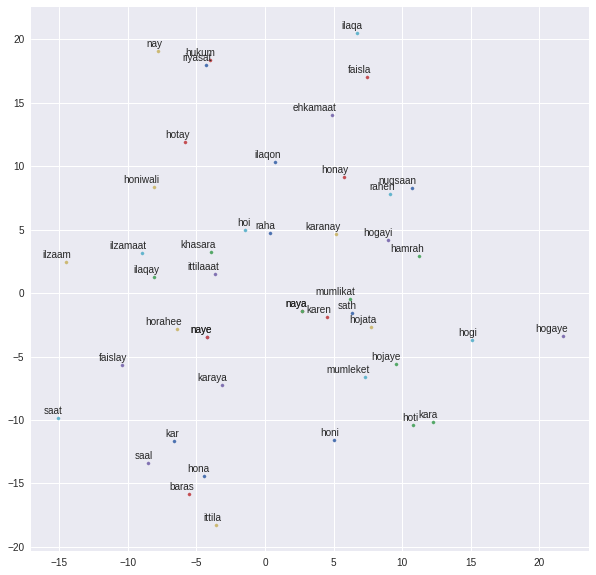

In [53]:
plt.figure(figsize=(10,10))

#For synonyms
synonyms=['kar','kara','karen','karaya','karanay','mumleket','riyasat','mumlikat','naya','naye','nay','saat','sath','hamrah','hukum','ehkamaat','ilzaam','ilzamaat','nuqsaan','khasara','baras'
,'saal','horahee','hoi','honi','hoti','hotay','hogaye','honiwali','hogi','hona','hojaye','honay','hogayi','hojata','rahen','raha','naya','naye','ittilaaat','ittila','ilaqa','ilaqon','ilaqay','faisla','faislay']
print('length of list:',len(synonyms))


synonyms_dict={k: v for v, k in enumerate(synonyms)}
'''
synonyms_dict={k: v for v, k in enumerate(synonyms)}
lst=[]

for i in synonyms:
  word = i
  inputs = autograd.Variable(torch.LongTensor([word_to_ix[word]]))
  vec = model.embeddings(inputs).data[0]
  vec = vec.numpy()
  lst.append(vec)
  
tsneList = TSNE(n_components=2).fit_transform(lst)

for i in range(len(tsneList)):
  # For correct word display on the graph
  ind = synonyms[i]
  word = synonyms[i]
  x, y = tsneList[i][0], tsneList[i][1]
  #print(word, x, y)
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph1.png")
'''

for i in synonyms:
  output=tsne_list[synonyms_dict[i]]
  x, y = output[0], output[1]
  plt.scatter(x, y,s=10)
  plt.annotate(i, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph1.png")


length of list: 24


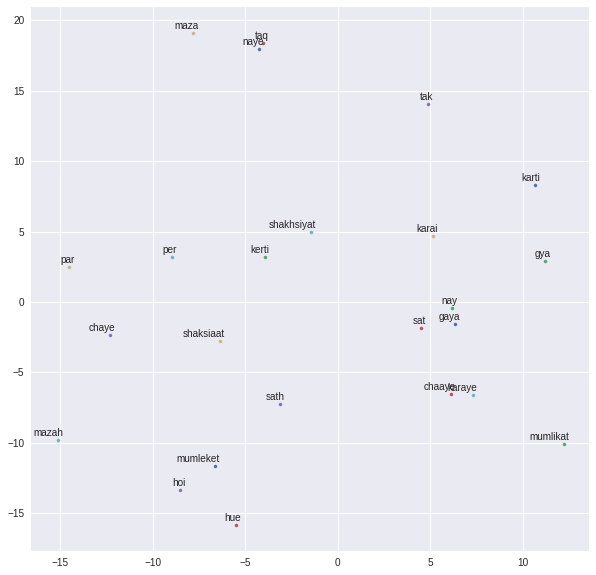

In [54]:
plt.figure (figsize=(10,10))
#For misspelled words
misspelled=['mumleket','mumlikat','sat','sath','karai','karaye','naye','nay','chaaye','chaye','maza','mazah','gaya','gya','taq','tak','par','per','karti','kerti','hue','hoi','shaksiaat','shakhsiyat']
print('length of list:',len(misspelled))

misspelled_dict={k: v for v, k in enumerate(misspelled)}
lst=[]
'''
for i in misspelled:
  word = i
  inputs = autograd.Variable(torch.LongTensor([word_to_ix[word]]))
  vec = model.embeddings(inputs).data[0]
  vec = vec.numpy()
  lst.append(vec)
  
tsneList = TSNE(n_components=2).fit_transform(lst)

for i in range(len(tsneList)):
  # For correct word display on the graph
  ind = misspelled[i]
  word = misspelled[i]
  x, y = tsneList[i][0], tsneList[i][1]
  #print(word, x, y)
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph2.png")
'''
for i in misspelled:
  output=tsne_list[misspelled_dict[i]]
  x, y = output[0], output[1]
  plt.scatter(x, y,s=10)
  plt.annotate(i, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph2.png")


length of list: 16


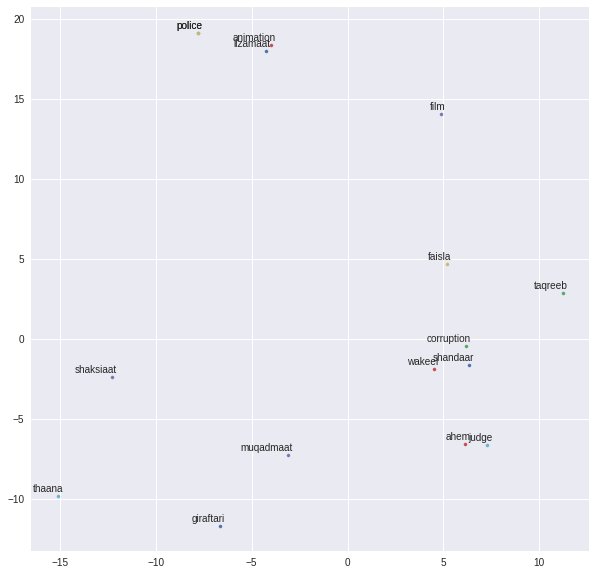

In [55]:
plt.figure (figsize=(10,10))
#For analogies
analogy=['giraftari','police','wakeel','muqadmaat','faisla','judge','ilzamaat','corruption','ahem','shaksiaat','police','thaana','shandaar', 'taqreeb','animation','film']
print('length of list:',len(analogy))
analogy_dict={k: v for v, k in enumerate(analogy)}
lst=[]

'''

for i in analogy:
  word = i
  inputs = autograd.Variable(torch.LongTensor([word_to_ix[word]]))
  vec = model.embeddings(inputs).data[0]
  vec = vec.numpy()
  lst.append(vec)
  
tsneList = TSNE(n_components=2).fit_transform(lst)

for i in range(len(tsneList)):
  # For correct word display on the graph
  ind = analogy[i]
  word = analogy[i]
  x, y = tsneList[i][0], tsneList[i][1]
  #print(word, x, y)
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph3.png")
'''
for i in analogy:
  output=tsne_list[analogy_dict[i]]
  x, y = output[0], output[1]
  plt.scatter(x, y,s=10)
  plt.annotate(i, xy=(x, y), xytext=(5, 2),textcoords='offset points', ha='right', va='bottom')
  plt.savefig("graph3.png")


##Results


**Describe the process of scraping, provide urls used for scrapping and develop plain corpus.**

The loop runs on a specified range and then beautiful soup is used to parse the html (articles) corresponding to the numbers in range. Then the data obtained is cleaned by removing all html tags, punctuation marks and numerical values since we are looking for roman Urdu words. The links used are given below:

https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe

https://stackoverflow.com/questions/16121001/suggestions-on-get-text-in-beautifulsoup
 
 
 **Run skip gram word embedding algorithm with:**

**a)	k=2,5,10,15,20**

CONTEXT_SIZE (k)= 2

EMBEDDING_DIM (dimensions)= 2

EPOCHS = 5

Epoch 0 Loss: 261641.21875
Beginning epoch 1

Epoch 1 Loss: 259683.51562
Beginning epoch 2

Epoch 2 Loss: 258116.34375
Beginning epoch 3

Epoch 3 Loss: 256806.00000
Beginning epoch 4

Epoch 4 Loss: 255678.90625


CONTEXT_SIZE = 5

EMBEDDING_DIM = 2

EPOCHS = 10

Epoch 0 Loss: 712534.06250
Beginning epoch 1

Epoch 1 Loss: 670855.31250
Beginning epoch 2

Epoch 2 Loss: 654694.25000
Beginning epoch 3

Epoch 3 Loss: 646409.62500
Beginning epoch 4

Epoch 4 Loss: 640835.93750
Beginning epoch 5

Epoch 5 Loss: 636606.93750
Beginning epoch 6

Epoch 6 Loss: 633237.62500
Beginning epoch 7

Epoch 7 Loss: 630440.00000
Beginning epoch 8

Epoch 8 Loss: 628069.25000
Beginning epoch 9

Epoch 9 Loss: 626031.56250

CONTEXT_SIZE = 10

EMBEDDING_DIM = 2

EPOCHS = 10

Epoch 0 Loss: 1388236.62500
Beginning epoch 1

Epoch 1 Loss: 1302604.00000
Beginning epoch 2

Epoch 2 Loss: 1277561.75000
Beginning epoch 3

Epoch 3 Loss: 1263383.62500
Beginning epoch 4

Epoch 4 Loss: 1253772.25000
Beginning epoch 5

Epoch 5 Loss: 1246742.62500
Beginning epoch 6

Epoch 6 Loss: 1241430.12500
Beginning epoch 7

Epoch 7 Loss: 1237222.75000
Beginning epoch 8

Epoch 8 Loss: 1233812.50000
Beginning epoch 9

Epoch 9 Loss: 1231008.00000
	

CONTEXT_SIZE = 15

EMBEDDING_DIM = 2

EPOCHS = 10

Epoch 0 Loss: 2057541.37500
Beginning epoch 1

Epoch 1 Loss: 1931330.25000
Beginning epoch 2

Epoch 2 Loss: 1896187.50000
Beginning epoch 3

Epoch 3 Loss: 1877029.37500
Beginning epoch 4

Epoch 4 Loss: 1864735.12500
Beginning epoch 5

Epoch 5 Loss: 1856215.12500
Beginning epoch 6

Epoch 6 Loss: 1849955.87500
Beginning epoch 7

Epoch 7 Loss: 1845183.37500
Beginning epoch 8

Epoch 8 Loss: 1841484.75000
Beginning epoch 9

Epoch 9 Loss: 1838495.12500

CONTEXT_SIZE = 20

EMBEDDING_DIM = 2

EPOCHS = 10

Epoch 1 Loss: 2541476.75000
Beginning epoch 2

Epoch 2 Loss: 2500793.25000
Beginning epoch 3

Epoch 3 Loss: 2478519.25000
Beginning epoch 4

Epoch 4 Loss: 2464712.75000
Beginning epoch 5

Epoch 5 Loss: 2455343.00000
Beginning epoch 6

Epoch 6 Loss: 2448592.00000
Beginning epoch 7

Epoch 7 Loss: 2443462.50000
Beginning epoch 8

Epoch 8 Loss: 2439401.50000
Beginning epoch 9

Epoch 9 Loss: 2436073.50000

**b)	For embedding dimension=100,200,300**

CONTEXT_SIZE = 2

EMBEDDING_DIM = 100

EPOCHS = 10

Epoch 0 Loss: 286755.81250
Beginning epoch 1

Epoch 1 Loss: 269985.53125
Beginning epoch 2

Epoch 2 Loss: 258952.54688
Beginning epoch 3

Epoch 3 Loss: 250973.20312
Beginning epoch 4

Epoch 4 Loss: 244771.20312
Beginning epoch 5

Epoch 5 Loss: 239728.26562
Beginning epoch 6

Epoch 6 Loss: 235476.17188
Beginning epoch 7

Epoch 7 Loss: 231787.03125
Beginning epoch 8

Epoch 8 Loss: 228523.10938
Beginning epoch 9

Epoch 9 Loss: 225593.12500

CONTEXT_SIZE = 2

EMBEDDING_DIM = 200

EPOCHS = 10

Epoch 0 Loss: 284255.34375
Beginning epoch 1

Epoch 1 Loss: 262333.25000
Beginning epoch 2

Epoch 2 Loss: 248253.56250
Beginning epoch 3

Epoch 3 Loss: 238080.81250
Beginning epoch 4

Epoch 4 Loss: 230127.62500
Beginning epoch 5

Epoch 5 Loss: 223586.43750
Beginning epoch 6

Epoch 6 Loss: 218014.81250
Beginning epoch 7

Epoch 7 Loss: 213148.81250
Beginning epoch 8

Epoch 8 Loss: 208826.32812
Beginning epoch 9

Epoch 9 Loss: 204941.98438

CONTEXT_SIZE = 2

EMBEDDING_DIM = 300

EPOCHS = 10

Epoch 0 Loss: 281219.37500
Beginning epoch 1

Epoch 1 Loss: 255363.57812
Beginning epoch 2

Epoch 2 Loss: 239372.95312
Beginning epoch 3

Epoch 3 Loss: 227796.10938
Beginning epoch 4

Epoch 4 Loss: 218648.40625
Beginning epoch 5

Epoch 5 Loss: 211063.84375
Beginning epoch 6

Epoch 6 Loss: 204597.23438
Beginning epoch 7

Epoch 7 Loss: 198975.20312
Beginning epoch 8

Epoch 8 Loss: 194019.29688
Beginning epoch 9

Epoch 9 Loss: 189606.40625



##References:


https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe
https://stackoverflow.com/questions/16121001/suggestions-on-get-text-in-beautifulsoup
https://stackoverflow.com/questions/10993612/python-removing-xa0-from-string